In [1]:
sys.path.append('../')
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
pd.set_option('max_columns', None)
import os

In [2]:
%%capture
from tqdm import tqdm_notebook

In [3]:
df = pd.read_csv('../checkpoints/litho_data_3.csv.gz', compression='gzip') # already non-null litho classes

In [4]:
df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME,DRDN,AI,LITHOLOGY_GEOLINK_2,LITHOLOGY_GEOLINK_3
0,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,6,2215.917725,15_9-12,7.184164,317.241248,5,5
1,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,6,2216.070068,15_9-12,6.203159,302.098359,5,5
2,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,6,2216.222412,15_9-12,4.952206,283.411635,5,5
3,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,6,2216.375000,15_9-12,4.664760,268.071435,5,5
4,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,6,2216.527344,15_9-12,5.164095,262.514429,5,5


In [5]:
litho_data = df.drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK', 'LITHOLOGY_GEOLINK_3', 'DRDN', 'AI']) # aiming litho classes 2 (average level of condensation)

In [6]:
litho_data['LITHOLOGY_GEOLINK_2'] = litho_data['LITHOLOGY_GEOLINK_2'].astype(int)

In [7]:
litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.8, .2], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [8]:
print(train.shape, litho_data.shape)

(1035897, 9) (1294715, 9)


In [9]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK_2', 'Set'])

Y = train['LITHOLOGY_GEOLINK_2']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [10]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (662973, 7) (662973,)
### Validation Dataset: ###  (165744, 7) (165744,)
### Test Dataset: ###  (207180, 7) (207180,)


In [11]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

torch.cuda.set_device(1)

In [12]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"gamma":0.9, "step_size":50},
                       gamma=1.2,
                       lambda_sparse=0, 
                       n_independent=10,
                       n_shared=5,	
                       n_steps=5,
                       n_a=64,
                       n_d=64,
                       momentum=0.6, # testar isso com  0.9 e 0.98
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') 

Device used : cuda


In [13]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.fit_transform(x_val)

In [14]:
max_epochs = 200

clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs,
    patience=30,
    num_workers=30,
    drop_last=False,
    batch_size=8192,
    virtual_batch_size=8192,
    weights=1
)

epoch 0  | loss: 3.16789 | train_balanced_accuracy: 0.44651 | valid_balanced_accuracy: 0.43998 |  0:00:59s
epoch 1  | loss: 1.53049 | train_balanced_accuracy: 0.60536 | valid_balanced_accuracy: 0.5928  |  0:01:59s
epoch 2  | loss: 1.07904 | train_balanced_accuracy: 0.67733 | valid_balanced_accuracy: 0.67559 |  0:02:59s
epoch 3  | loss: 0.82893 | train_balanced_accuracy: 0.754   | valid_balanced_accuracy: 0.74308 |  0:03:59s
epoch 4  | loss: 0.64462 | train_balanced_accuracy: 0.78718 | valid_balanced_accuracy: 0.7732  |  0:04:58s
epoch 5  | loss: 0.57309 | train_balanced_accuracy: 0.81295 | valid_balanced_accuracy: 0.79998 |  0:05:57s
epoch 6  | loss: 0.5601  | train_balanced_accuracy: 0.81435 | valid_balanced_accuracy: 0.79824 |  0:06:57s
epoch 7  | loss: 0.50107 | train_balanced_accuracy: 0.83151 | valid_balanced_accuracy: 0.81484 |  0:07:56s
epoch 8  | loss: 0.46063 | train_balanced_accuracy: 0.84126 | valid_balanced_accuracy: 0.82315 |  0:08:55s
epoch 9  | loss: 0.4385  | train_bala

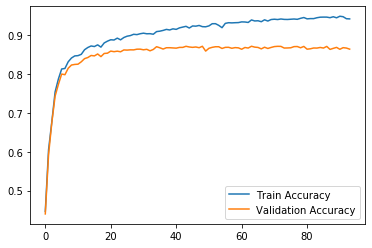

In [15]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

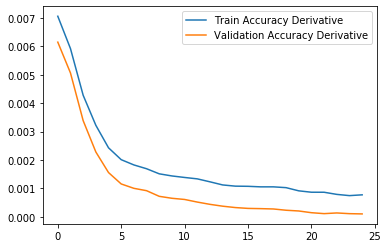

In [16]:
n_window = 70
plt.plot(np.gradient(pd.Series(clf.history['train_balanced_accuracy']).rolling(window=n_window).mean().iloc[n_window-1:].values), label='Train Accuracy Derivative')
plt.plot(np.gradient(pd.Series(clf.history['valid_balanced_accuracy']).rolling(window=n_window).mean().iloc[n_window-1:].values), label='Validation Accuracy Derivative')
plt.legend()
plt.show()

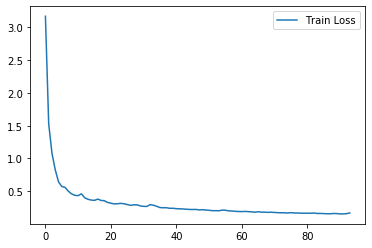

In [17]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()

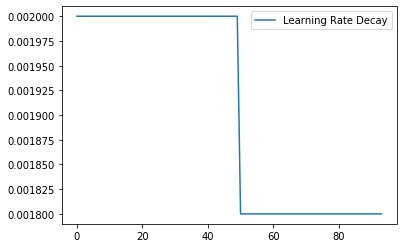

In [18]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()